### 1. Setup and Data Loading

In [1]:
# 1.1 Import libraries
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [2]:
# Directories
models_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "models"))
reports_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "reports"))
os.makedirs(reports_dir, exist_ok=True)

In [3]:
# 1.2 Load Data Artifacts

# TF-IDF data (for LR, CNB, SVC)
X_train_tfidf = joblib.load(os.path.join(models_dir, 'X_train_tfidf.pkl'))
X_test_tfidf  = joblib.load(os.path.join(models_dir, 'X_test_tfidf.pkl'))

# Count data (for MNB)
X_train_count = joblib.load(os.path.join(models_dir, 'X_train_count.pkl'))
X_test_count  = joblib.load(os.path.join(models_dir, 'X_test_count.pkl'))

# Labels
y_train = joblib.load(os.path.join(models_dir, 'y_train.pkl'))
y_test  = joblib.load(os.path.join(models_dir, 'y_test.pkl'))

print(f"TF-IDF train: {X_train_tfidf.shape}, test: {X_test_tfidf.shape}")
print(f"Count train:  {X_train_count.shape}, test: {X_test_count.shape}")

TF-IDF train: (4135, 5001), test: (1034, 5001)
Count train:  (4135, 5001), test: (1034, 5001)


### 2. Helper Function

In [10]:
def evaluate_model(name, model, X_test, y_test, reports_dir):
    """Evaluate model, print metrics, and save confusion matrix."""
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(os.path.join(reports_dir, f"{name}_confusion_matrix.png"))
    plt.show()
    plt.close()

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    }

### 2. Define Models and Tuning Config

In [14]:
# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Best MNB Params: {'alpha': 1.0, 'fit_prior': True}

=== MultinomialNB ===
              precision    recall  f1-score   support

           0      0.985     0.992     0.988       903
           1      0.944     0.893     0.918       131

    accuracy                          0.980      1034
   macro avg      0.964     0.943     0.953      1034
weighted avg      0.979     0.980     0.979      1034



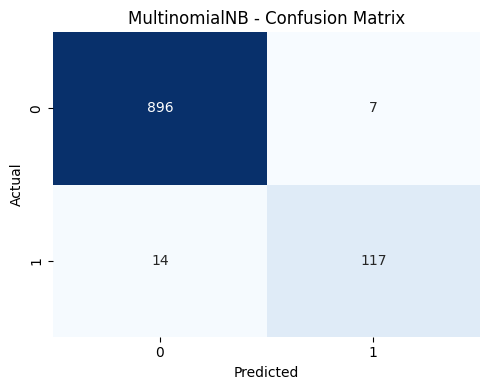

In [15]:
# 2.1 MNB
mnb = MultinomialNB()
mnb_params = {
    'alpha': [0.01, 0.05, 0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}
mnb_grid = GridSearchCV(mnb, mnb_params, cv=cv, scoring='f1_weighted', n_jobs=-1)
mnb_grid.fit(X_train_count, y_train)

best_mnb = mnb_grid.best_estimator_
print(f"Best MNB Params: {mnb_grid.best_params_}")

mnb_results = evaluate_model("MultinomialNB", best_mnb, X_test_count, y_test, reports_dir)

Best CNB Params: {'alpha': 0.5, 'norm': True}

=== ComplementNB ===
              precision    recall  f1-score   support

           0      0.984     0.980     0.982       903
           1      0.867     0.893     0.880       131

    accuracy                          0.969      1034
   macro avg      0.926     0.937     0.931      1034
weighted avg      0.970     0.969     0.969      1034



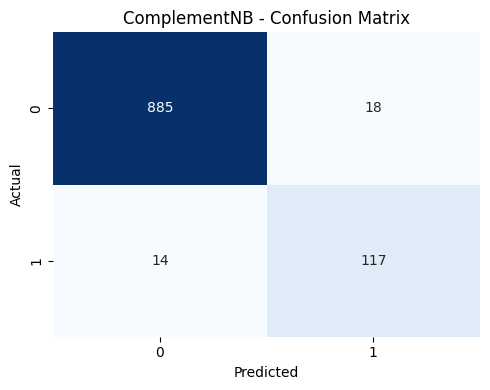

In [17]:
# 2.2 CNB
cnb = ComplementNB()
cnb_params = {
    'alpha': [0.01, 0.05, 0.1, 0.5, 1.0],
    'norm': [True, False]
}
cnb_grid = GridSearchCV(cnb, cnb_params, cv=cv, scoring='f1_weighted', n_jobs=-1)
cnb_grid.fit(X_train_tfidf, y_train)

best_cnb = cnb_grid.best_estimator_
print(f"Best CNB Params: {cnb_grid.best_params_}")

cnb_results = evaluate_model("ComplementNB", best_cnb, X_test_tfidf, y_test, reports_dir)

Best LR Params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

=== LogisticRegression ===
              precision    recall  f1-score   support

           0      0.986     0.987     0.986       903
           1      0.908     0.901     0.904       131

    accuracy                          0.976      1034
   macro avg      0.947     0.944     0.945      1034
weighted avg      0.976     0.976     0.976      1034



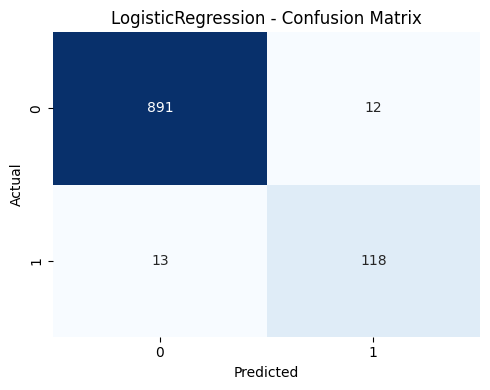

In [18]:
# 2.3 LR
lr = LogisticRegression(max_iter=1000)
lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}
lr_grid = GridSearchCV(lr, lr_params, cv=cv, scoring='f1_weighted', n_jobs=-1)
lr_grid.fit(X_train_tfidf, y_train)

best_lr = lr_grid.best_estimator_
print(f"Best LR Params: {lr_grid.best_params_}")

lr_results = evaluate_model("LogisticRegression", best_lr, X_test_tfidf, y_test, reports_dir)

Best SVC Params: {'C': 1, 'class_weight': 'balanced', 'loss': 'squared_hinge'}

=== LinearSVC ===
              precision    recall  f1-score   support

           0      0.982     0.991     0.987       903
           1      0.935     0.878     0.906       131

    accuracy                          0.977      1034
   macro avg      0.959     0.935     0.946      1034
weighted avg      0.976     0.977     0.976      1034



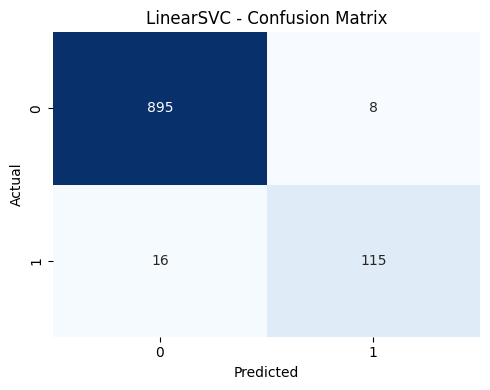

In [19]:
# 2.4 SVC
svc = LinearSVC()
svc_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'loss': ['hinge', 'squared_hinge'],
    'class_weight': [None, 'balanced']
}
svc_grid = GridSearchCV(svc, svc_params, cv=cv, scoring='f1_weighted', n_jobs=-1)
svc_grid.fit(X_train_tfidf, y_train)

best_svc = svc_grid.best_estimator_
print(f"Best SVC Params: {svc_grid.best_params_}")

svc_results = evaluate_model("LinearSVC", best_svc, X_test_tfidf, y_test, reports_dir)

In [21]:
# 2.5 Compare all models
results_df = pd.DataFrame([mnb_results, cnb_results, lr_results, svc_results])
results_df = results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

print("\n=== Model Comparison ===")
display(results_df)

best_model_name = results_df.iloc[0]["Model"]
print(f"\n🏆 Best Performing Model: {best_model_name}")


=== Model Comparison ===


,Model,Accuracy,Precision,Recall,F1-Score
0,MultinomialNB,0.979691,0.943548,0.893130,0.917647
1,LinearSVC,0.976789,0.934959,0.877863,0.905512
2,LogisticRegression,0.975822,0.907692,0.900763,0.904215
3,ComplementNB,0.969052,0.866667,0.893130,0.879699



🏆 Best Performing Model: MultinomialNB
